# Project - Cell Tracking in different type of matrigel

### (DATA PRESENTED HERE ARE SWIMMING ALGAE)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

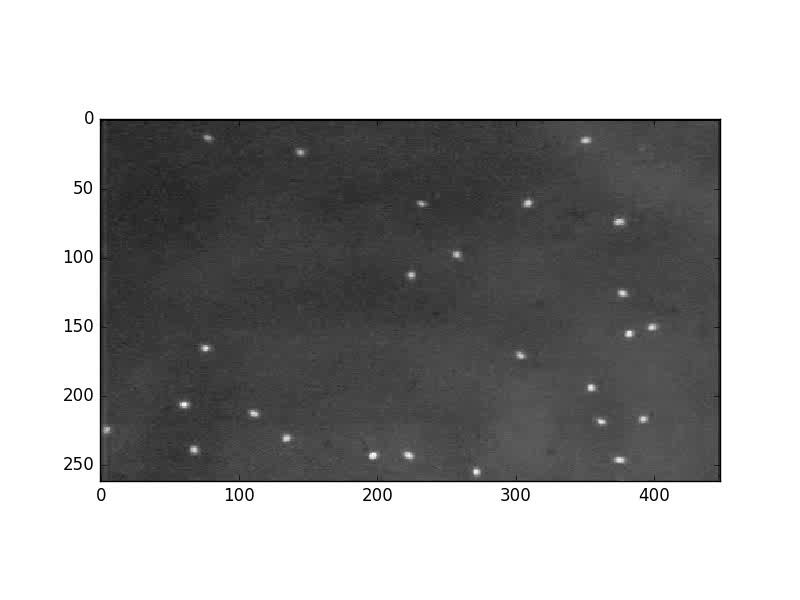

In [17]:
from IPython.display import Image
Image('swimmingalgae.gif', format='jpg', width=500)

In [4]:
from tracking import *
from flatten_images import *
from plot_track import *
from analysis_track import *
from skimage import io
from IPython.html.widgets import interact, fixed, IntSlider

In [5]:
img = io.imread("SwimmingAlgae.tif")

In [6]:
nt, ny, nx = img.shape

## Widget

You can use the notebook to interact with the data.

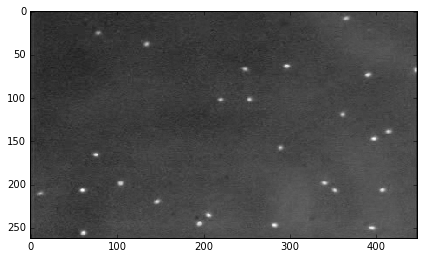

In [7]:
@interact(image = fixed(img), x=(0, nt-1, 1))
def show_frame(image, x=5):
    io.imshow(image[x,:,:])

## Illumination Correction

In [8]:
img_divide = illumin_correct(img)

<function flatten_images.plot_profile_corrected_image>

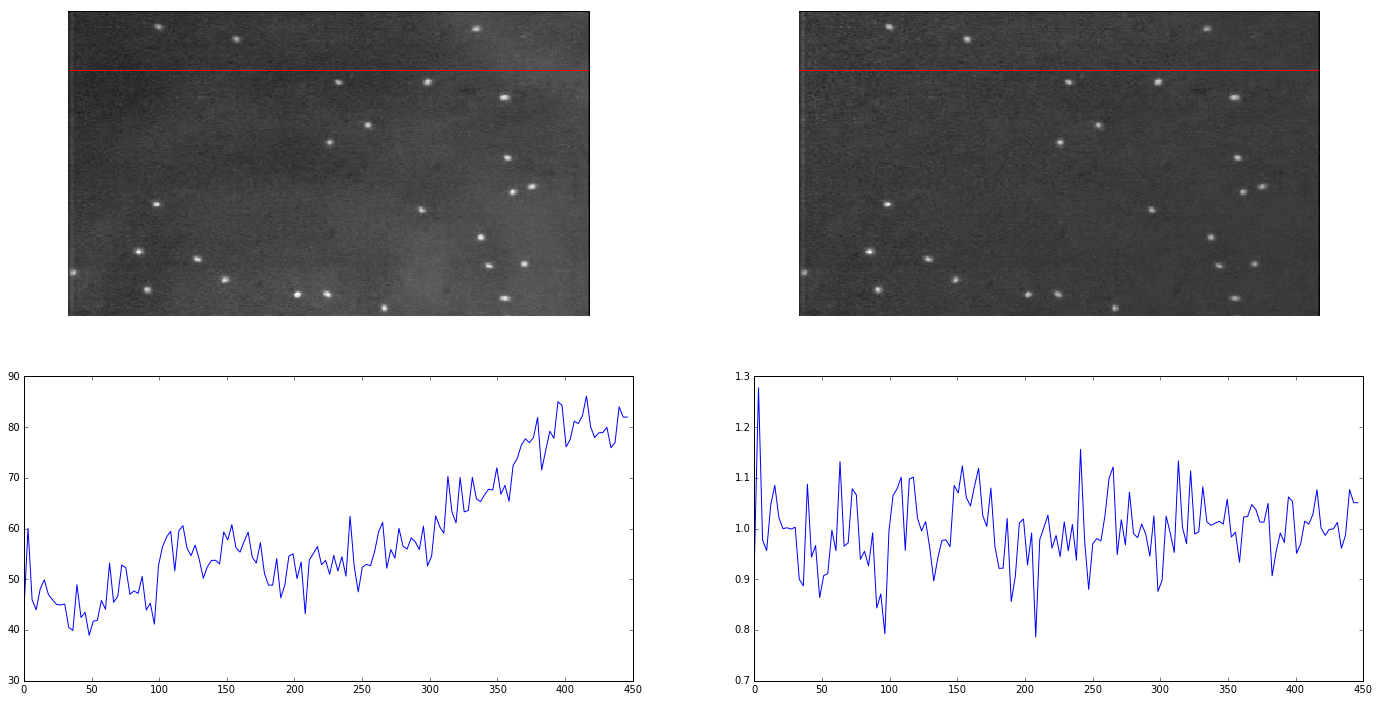

In [9]:
interact(plot_profile_corrected_image, img = fixed(img), img_divide = fixed(img_divide), 
         position = IntSlider(min=0,max=ny,step=1,value=50), 
         div = IntSlider(min=1,max=5,step=1,value=3))

In [10]:
local_maxima = Num_Blob(img_divide, nt)

In [11]:
liste_a = multiple_track_all(local_maxima, img)

## Plot

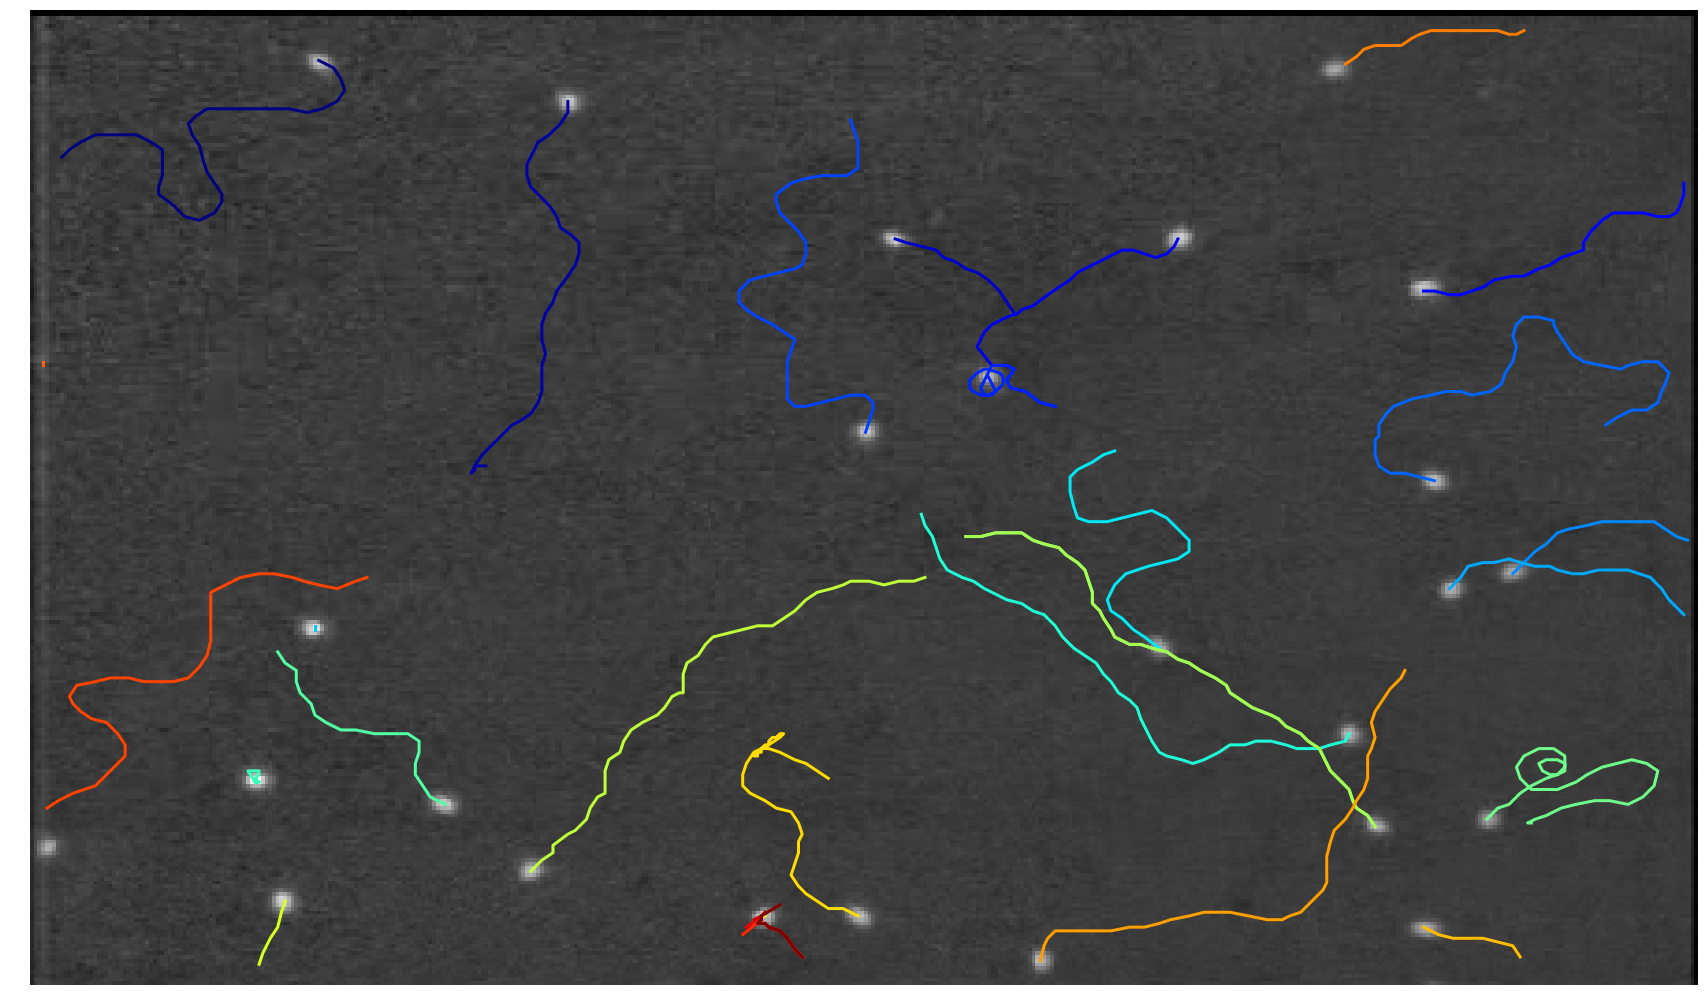

In [12]:
plot_track(img_divide, liste_a)

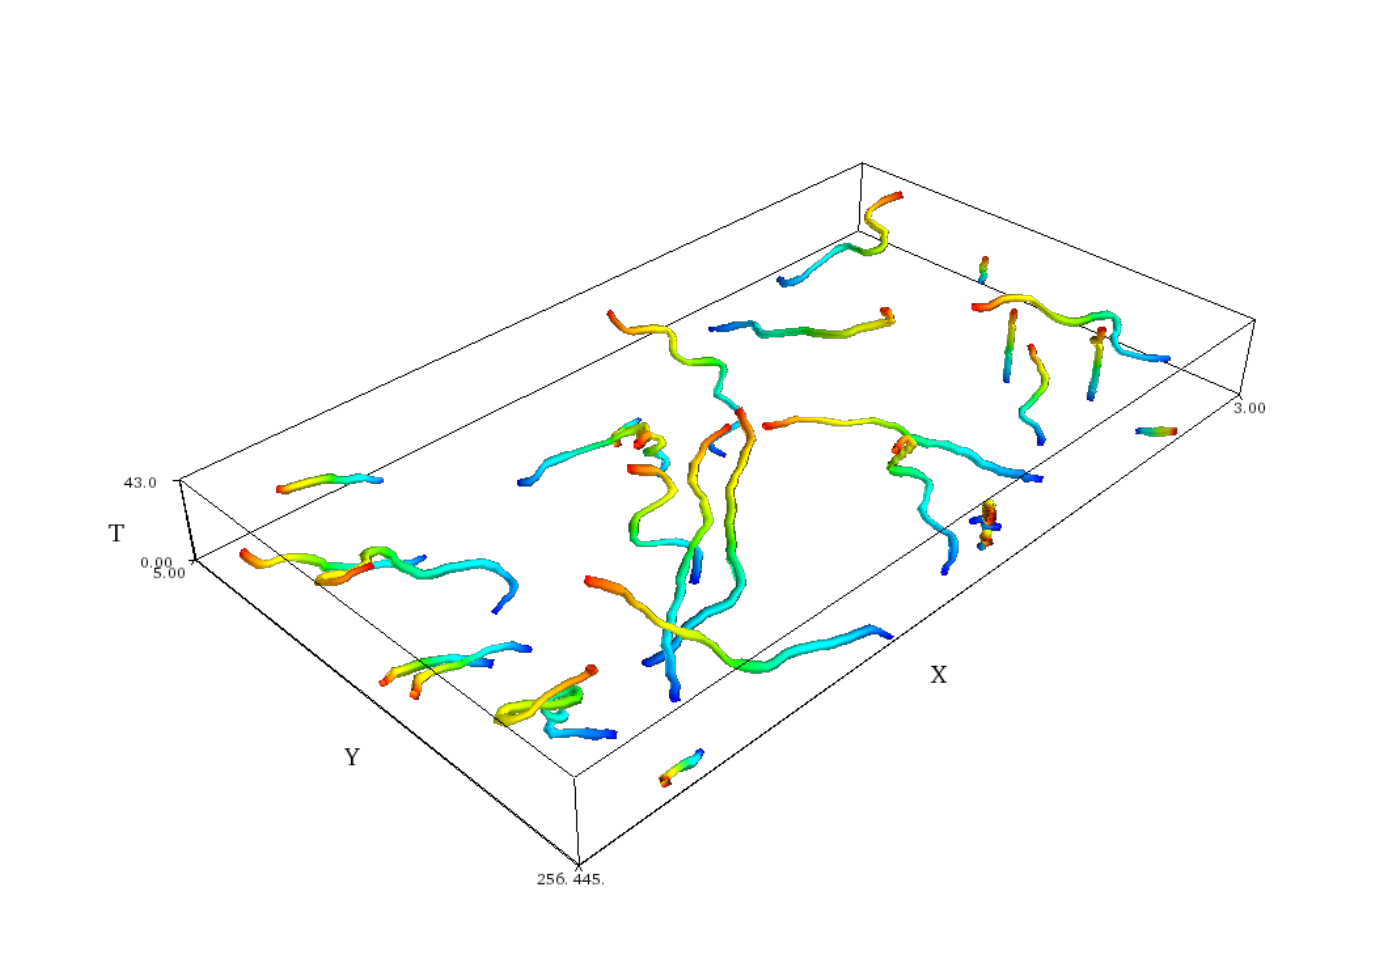

In [13]:
plot_track_3d(liste_a)

## Analysis of the trajectories

In [14]:
trajectories = create_dataframe(local_maxima, liste_a)

### Mean Square Displacement

The mean square displacement for a time difference Δt is computed as the squared distance between the position of the particle at time t and its position at time t+Δt averaged over each successive time t:

$\mbox{MSD}(\Delta t) = \frac{\sum_0^{T - \Delta t} ||\mathbf{r}(t + \Delta t) - \mathbf{r}(t)||^2}{(T - \Delta t) / \delta t} = \frac{d_{t, t+\Delta t}}{(T - \Delta t) / \delta t}$

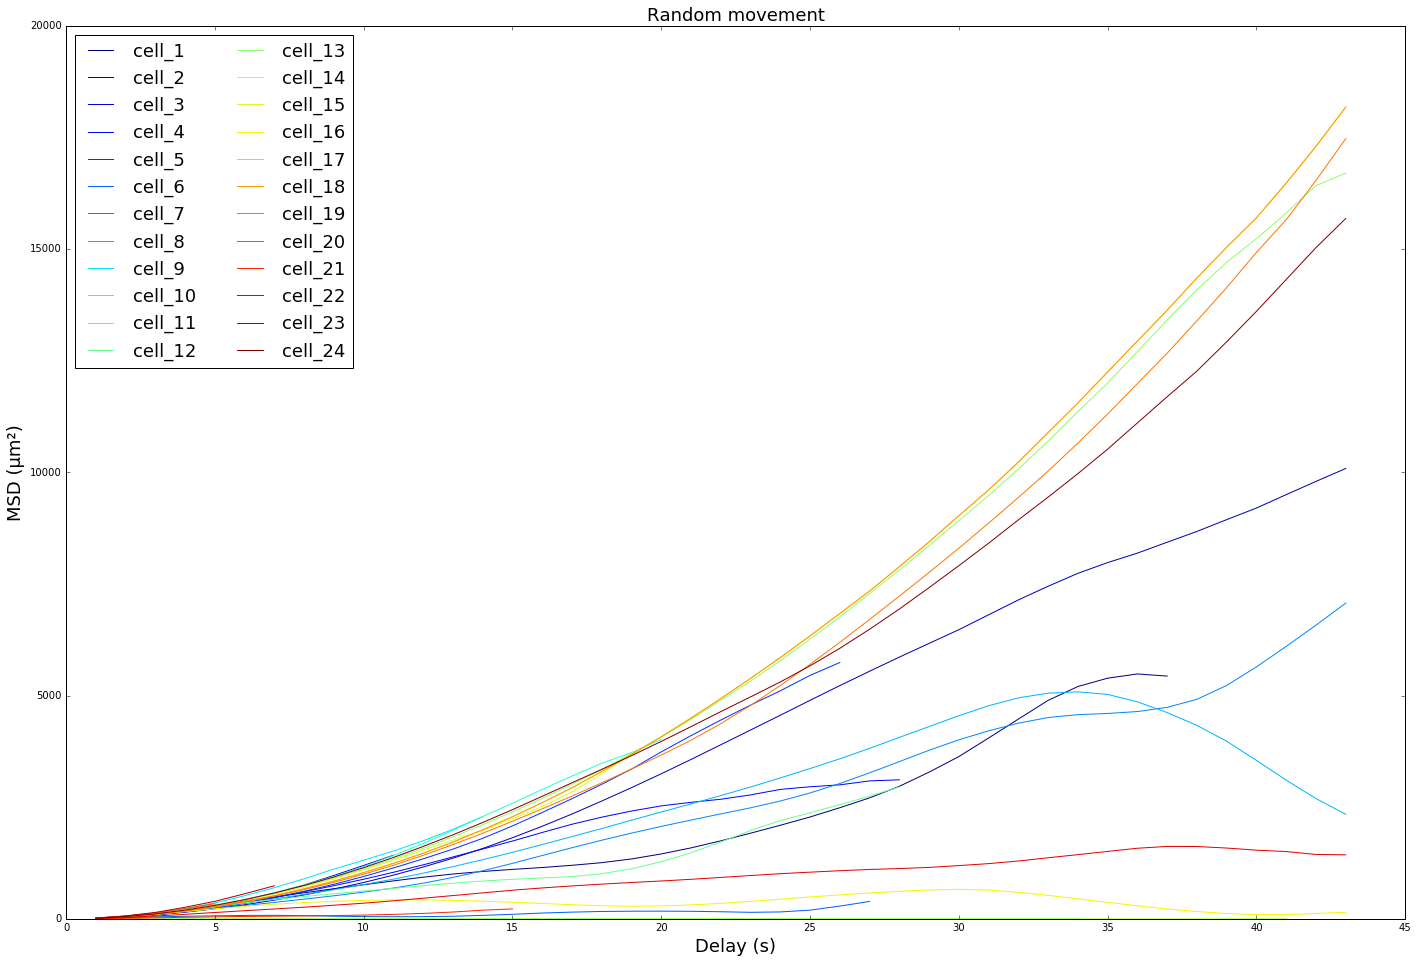

In [15]:
plot_MSD(trajectories)